#Importation of libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
from transformers import BertModel

#Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import csv
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


#BERT Model

In [5]:
# Pre-trained BERT model variant
model_name = 'bert-base-uncased'

# Loading the pre-trained BERT model
bert_model = BertModel.from_pretrained(model_name)

# Loading the corresponding tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##Data preprocessing

In [6]:
# Maximum sequence length for BERT
max_length = 512

# Preprocessing text data
def preprocess_text(text, tokenizer, max_length):
    # Tokenize the text
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Extract input_ids tensor
    input_ids = tokenized_text['input_ids']

    return input_ids

# Filter out rows with missing values in the 'full_text' column
train_df = train_df.dropna(subset=['full_text'])

# Preprocess the 'full_text' column
train_df['tokenized_text'] = train_df['full_text'].apply(lambda x: preprocess_text(x, tokenizer, max_length))

##Model architecture

In [8]:
class BertRegressionModel(nn.Module):
    def __init__(self, pretrained_bert_model, num_regression_features):
        super(BertRegressionModel, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_bert_model)
        self.regression_head = nn.Linear(self.bert.config.hidden_size, num_regression_features)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        regression_output = self.regression_head(pooled_output)
        return regression_output

# In our project
pretrained_bert_model = 'bert-base-uncased'
num_regression_features = 6

# Initialize the regression model
model = BertRegressionModel(pretrained_bert_model, num_regression_features)

# Print the model architecture
print(model)

BertRegressionModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

##Tokenizing, Training and Results

Starting epoch 1/10
Epoch 1/10, Loss: 2.1061482199323858
Starting epoch 2/10
Epoch 2/10, Loss: 0.2905542920760023
Starting epoch 3/10
Epoch 3/10, Loss: 0.24074447409408847
Starting epoch 4/10
Epoch 4/10, Loss: 0.2153102840349926
Starting epoch 5/10
Epoch 5/10, Loss: 0.19265478134639863
Starting epoch 6/10
Epoch 6/10, Loss: 0.1694143375730127
Starting epoch 7/10
Epoch 7/10, Loss: 0.14708830694842145
Starting epoch 8/10
Epoch 8/10, Loss: 0.13739417105670867
Starting epoch 9/10
Epoch 9/10, Loss: 0.1247482270729251
Starting epoch 10/10
Epoch 10/10, Loss: 0.11652349795752424


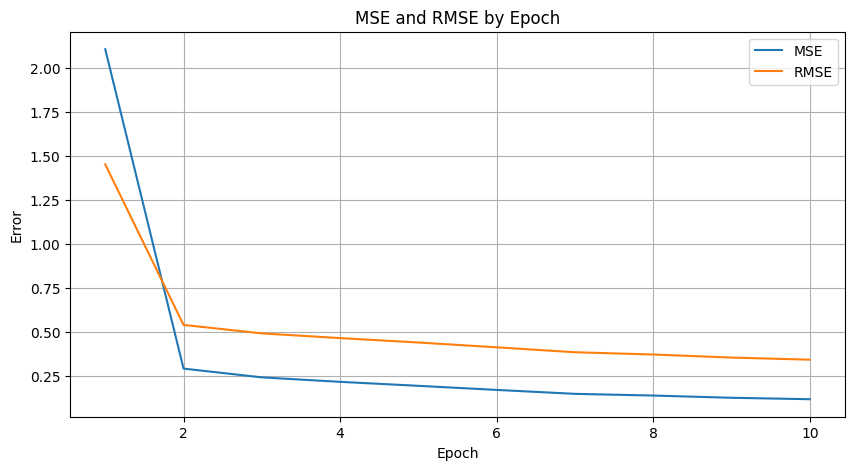

Metrics saved to /content/drive/MyDrive/BERT_model_metrics.npy


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length for BERT
max_length = 512

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']
        inputs = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
        targets = [float(self.data.iloc[idx].get(col, float('nan'))) for col in target_cols]

        targets = torch.tensor(targets, dtype=torch.float)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': targets
        }

train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_dataset = CustomDataset(train_df, tokenizer, max_length)

# Define hyperparameters
batch_size = 32
num_epochs = 10
# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class BertRegressionModel(nn.Module):
    def __init__(self):
        super(BertRegressionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.regression_head = nn.Linear(self.bert.config.hidden_size, 6)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        regression_output = self.regression_head(pooled_output)
        return regression_output

model = BertRegressionModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

mse = []
rmse = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    print(f'Starting epoch {epoch+1}/{num_epochs}')
    batch_count = 0
    for batch in train_dataloader:
        batch_count += 1
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        targets = batch['targets']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    mse.append(average_loss)
    rmse.append(np.sqrt(average_loss))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}')

# Plotting MSE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), mse, label='MSE')
plt.plot(range(1, num_epochs+1), rmse, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('MSE and RMSE by Epoch')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/BERT_model_performance_metrics.png')
plt.show()

# Saving the metrics to a file
metrics_path = '/content/drive/MyDrive/BERT_model_metrics.npy'
np.save(metrics_path, np.array([mse, rmse]))
print(f"Metrics saved to {metrics_path}")


##Predictions

In [10]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length for BERT
max_length = 512

class CustomTestDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']
        inputs = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze(0).to(device)  # Move to device
        attention_mask = inputs['attention_mask'].squeeze(0).to(device)  # Move to device

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

test_dataset = CustomTestDataset(test_df, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Function to make predictions
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.cpu().numpy())

    return predictions

# Make predictions
predictions = predict(model, test_dataloader)

# Output predictions
print(predictions)


[array([3.0779946, 2.9732296, 3.344056 , 3.313014 , 3.125123 , 2.9175496],
      dtype=float32), array([2.5230918, 2.399858 , 2.7282085, 2.4151566, 2.1761494, 2.7745285],
      dtype=float32), array([3.8724973, 3.5559175, 3.8069787, 3.738889 , 3.4812958, 3.76646  ],
      dtype=float32)]


In [11]:
# Save the model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/essay_grading_model_weights.pth')
